# Stress Test Climatique : Analyse du Risque de Crédit
Ce Notebook présente une simulation de l'impact financier du changement climatique sur un portefeuille de prêts.
L'objectif est de quantifier l'augmentation des pertes attendues (**ECL**) selon les scénarios du NGFS.

## Imports

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration esthétique
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Chemin du fichier
FILE_PATH = '/Users/axel/Documents/Travail_ESILV/2025/PI2/Réu3/portfolio_climat.xlsx'

def clean_val(x):
    if isinstance(x, str):
        x = x.replace('\xa0', '').replace(' ', '').replace(',', '.')
        return float(x.replace('%', '')) / 100 if '%' in x else float(x)
    return x

## Nettoyage

In [18]:
# Chargement des feuilles Excel
df_portfolio = pd.read_excel("portfolio_climat.xlsx", sheet_name='Portfolio')
df_uplifts = pd.read_excel("portfolio_climat.xlsx", sheet_name='Scenario_Uplifts')
df_countries = pd.read_excel("portfolio_climat.xlsx", sheet_name='Countries')

# Nettoyage des colonnes financières
df_portfolio['EAD_EUR'] = df_portfolio['EAD_EUR'].apply(clean_val)
df_portfolio['PD_base'] = df_portfolio['PD_base'].apply(clean_val)

# Fusion des données (Mapping Pays et Secteurs)
df = df_portfolio.merge(df_countries[['country', 'country_risk_factor']], on='country', how='left')
df = df.merge(df_uplifts, on='sector', how='left')

print(f"✅ Portefeuille chargé : {len(df)} lignes.")

✅ Portefeuille chargé : 35 lignes.


## Calculs Financiers

In [19]:
# 1. Calcul de base (Situation actuelle)
df['PD_Base'] = df['PD_base'] * df['country_risk_factor']
df['ECL_Base'] = df['EAD_EUR'] * df['PD_Base'] * df['LGD']

# 2. Simulation des scénarios (Optimiste, Neutre, Pessimiste)
scenario_losses = []
for sc in ['Optimiste', 'Neutre', 'Pessimiste']:
    df[f'PD_{sc}'] = df['PD_Base'] * (1 + df[f'pd_uplift_{sc}'])
    df[f'LGD_{sc}'] = df['LGD'] * (1 + df[f'lgd_uplift_{sc}'])
    df[f'ECL_{sc}'] = df['EAD_EUR'] * df[f'PD_{sc}'] * df[f'LGD_{sc}']

    # Calcul de la perte projetée (surplus lié au climat)
    df[f'loss_projected_{sc}'] = df[f'ECL_{sc}'] - df['ECL_Base']
    scenario_losses.append(df[f'ECL_{sc}'].sum())

# Calcul de l'uplift absolu pour les analyses suivantes
df['Uplift_ECL_Absolu'] = df['ECL_Pessimiste'] - df['ECL_Base']

## Indicateur de Solvabilité : Climate VaR
La **Climate Value-at-Risk (95%)** représente la perte maximale probable dans 95% des cas simulés.

In [20]:
c_var = np.percentile(scenario_losses, 95)
print(f"--- INDICATEUR RÉGLEMENTAIRE ---")
print(f"Climate VaR (95%) : {c_var:,.0f} €")

--- INDICATEUR RÉGLEMENTAIRE ---
Climate VaR (95%) : 10,487,066 €


## Visualisations

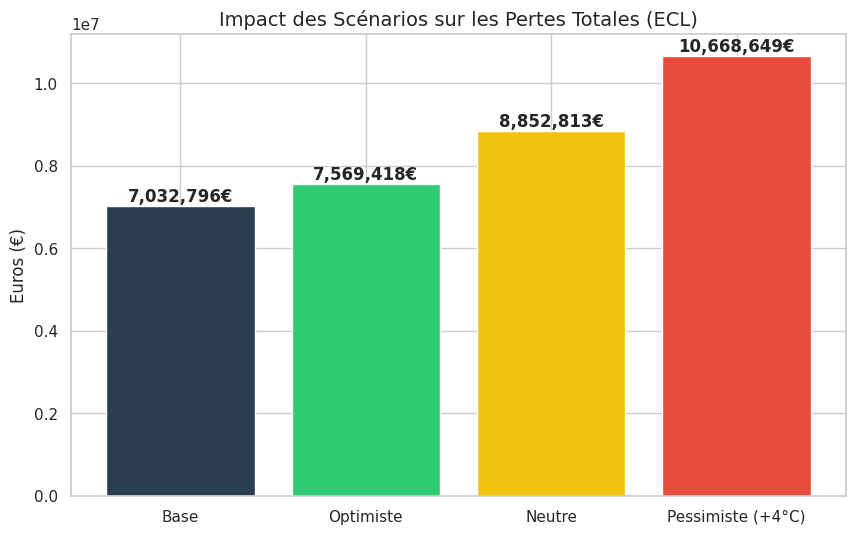

In [21]:
plt.figure(figsize=(10, 6))
totals = [df['ECL_Base'].sum(), df['ECL_Optimiste'].sum(), df['ECL_Neutre'].sum(), df['ECL_Pessimiste'].sum()]
labels = ['Base', 'Optimiste', 'Neutre', 'Pessimiste (+4°C)']
colors = ['#2b3d50', '#2ecc71', '#f1c40f', '#e74c3c']

bars = plt.bar(labels, totals, color=colors)
plt.title("Impact des Scénarios sur les Pertes Totales (ECL)", fontsize=14)
plt.ylabel("Euros (€)")

# Ajout des étiquettes de montants sur les barres
for i, v in enumerate(totals):
    plt.text(i, v, f"{v:,.0f}€", ha='center', va='bottom', fontweight='bold')

plt.show()

## Analyse de la Dégradation du Crédit

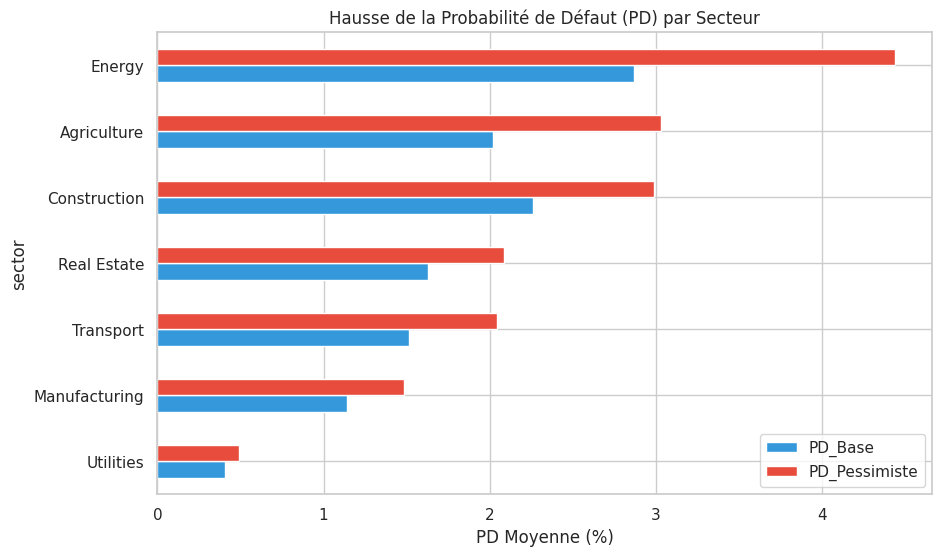

In [22]:
# Comparaison PD Base vs Pessimiste par secteur
sector_pd = df.groupby('sector')[['PD_Base', 'PD_Pessimiste']].mean() * 100
sector_pd.sort_values('PD_Pessimiste').plot(kind='barh', color=['#3498db', '#e74c3c'])
plt.title("Hausse de la Probabilité de Défaut (PD) par Secteur")
plt.xlabel("PD Moyenne (%)")
plt.show()

## Cartographie de la Concentration (Heatmap)

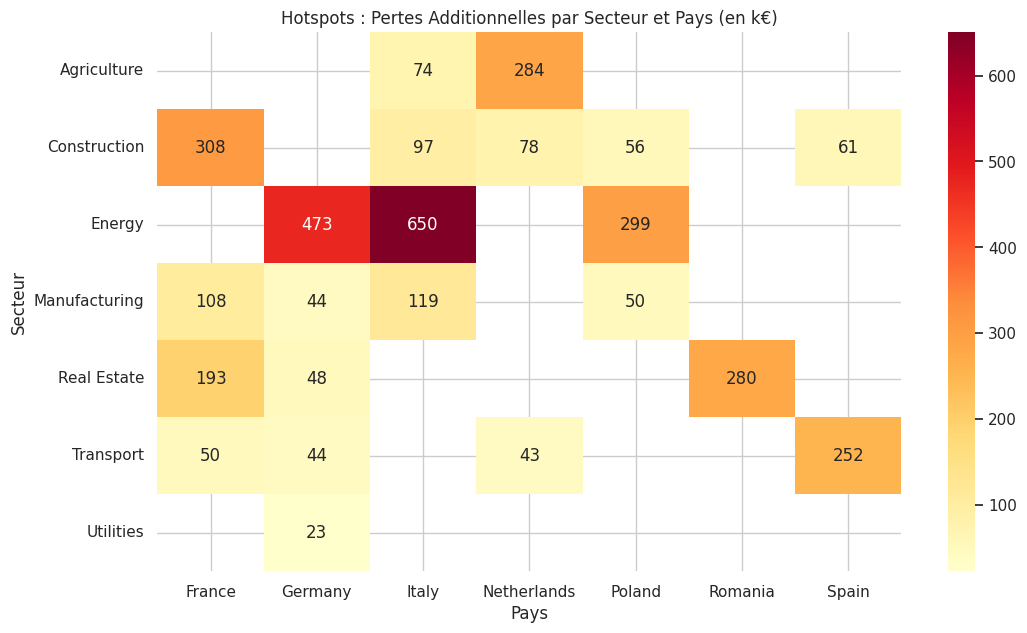

In [23]:
plt.figure(figsize=(12, 7))
heatmap_data = df.pivot_table(index='sector', columns='country', values='Uplift_ECL_Absolu', aggfunc='sum')
sns.heatmap(heatmap_data / 1000, annot=True, fmt=".0f", cmap="YlOrRd")
plt.title("Hotspots : Pertes Additionnelles par Secteur et Pays (en k€)")
plt.xlabel("Pays")
plt.ylabel("Secteur")
plt.show()

## Analyse des Lignes Individuelles (Top 10)

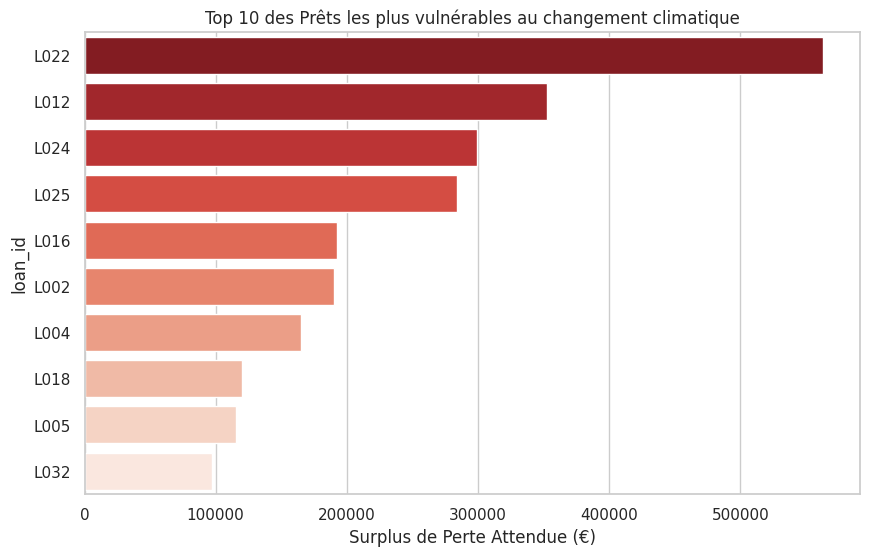

In [24]:
plt.figure(figsize=(10, 6))
top_10 = df.nlargest(10, 'Uplift_ECL_Absolu')
sns.barplot(data=top_10, x='Uplift_ECL_Absolu', y='loan_id', hue='loan_id', palette='Reds_r', legend=False)
plt.title("Top 10 des Prêts les plus vulnérables au changement climatique")
plt.xlabel("Surplus de Perte Attendue (€)")
plt.show()

## Conclusion

In [25]:
# Exportation pour les régulateurs
df.to_excel('Reporting_Complet_Risque_Climat.xlsx', index=False)
print("✅ Rapport exporté avec succès.")

✅ Rapport exporté avec succès.
